In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import scipy.integrate
import scipy.optimize as opt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# activating the command below will cause matplotlib to use 'TEX' to interpret every text
#, but choices of font styles in TEX are limited, so avoid using 'TEX' but rather us
# matploblib's own font/styles, etc.
# plt.rc('text', usetex=True)    
# plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{textcomp}')

%matplotlib inline 
# options: 'notebook' or 'inline'


# default parameter values

F_ht_0 = 1.3e10
F_a_0  = 1.1e10
F_lt_0 = 1.2e10

F_r_modern = 1e10
fraction   = 0.2

F_r_0 = fraction*F_r_modern   # river flux, modern value is 1e10 mol/yr
M0    = 3.575e16
R_std = 1/0.082757 # used for conversion between ratio values and delta values
                   # from James and Palmer (Chemical Geology)

delta_r_d  = 0.023
delta_ht_d = 0.0083
Delta_lt_d = -0.008 # Note this is delta_lt - delta_seawater 
Delta_a_d  = -0.01  # Note this is delta_a - delta_seawater 

### Plot for M(t)

In [3]:
a          = F_r_0 + F_ht_0
b          = (F_a_0 + F_lt_0)/M0
c          = a/b
max_time   = 10.0   # in Ma

time_span  = (0, max_time)   # in Ma
time_step  = np.linspace(0, max_time, num=2000, endpoint=True)  # time for the solution points
M_values   = c - (c - M0) *np.exp(-b*time_step*1e6)

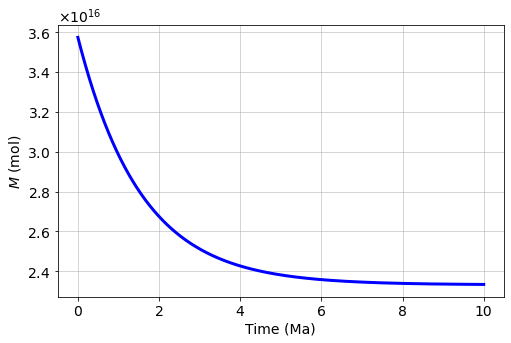

In [4]:
FONT_SIZE = 14
lw        = 3

f = plt.figure(figsize=(8,5))   # results for a default fixed Delta_m = 0.02, plotted for sanity check

# formatter for yaxis tick labels
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.plot(time_step, M_values, color='b', linewidth=lw)
plt.xlabel('Time (Ma)', size=FONT_SIZE)
plt.ylabel(r'$M$ (mol)', size=FONT_SIZE)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.get_offset_text().set_fontsize(FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
plt.grid(which='major', alpha=0.65)

#f.savefig('default-reservoir-new.png', dpi = 300)

### Solve for R(t)

In [5]:
delta0      = 0.031   # initial delta of Li
R_0         = (delta0+1)*R_std  # converted to initial ratio
R_r_d       = (delta_r_d+1)*R_std  # river
R_ht_d      = (delta_ht_d+1)*R_std  # hydrothermal input

ep_a_d      = Delta_a_d*R_std  # epsilon for clay formation
ep_lt_d     = Delta_lt_d*R_std  # epsilon for oceanic alteration

In [6]:
# Numerical ODE of Equation (9)

def gov_eq(t, y, F_r=F_r_0, F_ht=F_ht_0, F_a=F_a_0, F_lt=F_lt_0, R_r=R_r_d, R_ht=R_ht_d, ep_lt=ep_lt_d, ep_a=ep_a_d):
    
    a     = F_r + F_ht
    b     = (F_a + F_lt)/M0
    c     = a/b
    M     = c - (c - M0) *np.exp(-b*t) # note here unit of t is yr
    dRdt  = ((1+y)/M)*(F_r*(R_r-y)/(1+R_r) + F_ht*(R_ht-y)/(1+R_ht)) - ((1+y)/M0)*(F_lt*ep_lt/(1+ep_lt+y) + F_a*ep_a/(1+ep_a+y))
    
    return dRdt

In [7]:
y0         = [R_0]  # Initial Condition
time_span  = (0, max_time*1e6)   # Convert from Ma to yr
time_step  = np.linspace(0, time_span[-1], num=2000, endpoint=True)  # time for the solution points

In [8]:
time_span[-1]

10000000.0

In [9]:
sol = scipy.integrate.solve_ivp(gov_eq, time_span, y0, method='Radau', t_eval=time_step, rtol=1e-5, atol=1e-8)

In [10]:
deltaLi = (sol.y[0]/R_std - 1)   # convert from isotope ratios to the delta values

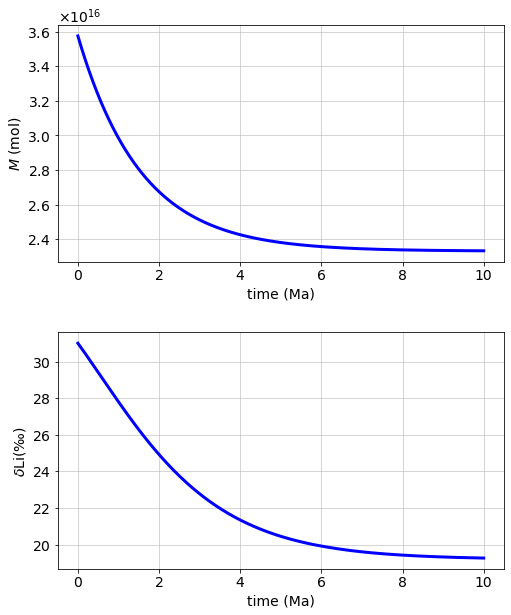

In [11]:
FONT_SIZE = 14
lw        = 3

f = plt.figure(figsize=(8,10))   # results for a default fixed Delta_m = 0.02, plotted for sanity check

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.subplot(2,1,1)
plt.plot(time_step/1e6, M_values, color='b', linewidth=lw)
plt.xlabel('time (Ma)', size=FONT_SIZE)
plt.ylabel(r'$M$ (mol)', size=FONT_SIZE)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.get_offset_text().set_fontsize(FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
plt.grid(which='major', alpha=0.65)

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.subplot(2,1,2)
plt.plot(sol.t/1e6, deltaLi*1e3, color='b', linewidth=lw)
plt.xlabel('time (Ma)', size=FONT_SIZE)
plt.ylabel(r'$\delta$Li' + '(\u2030)', size=FONT_SIZE)
plt.gca().yaxis.get_offset_text().set_fontsize(FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
plt.tick_params(labelsize=FONT_SIZE)
plt.grid(which='major', alpha=0.65)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
# f.savefig('default-new.png', dpi = 300)

### Now vary $\delta{\rm Li}_{\rm riv}$ and $F_{\rm riv}$ from their default values

In [17]:
delta_riv_range         = np.linspace(0.010, 0.023, num=100, endpoint=True)  # corresponds to delta_ from 0 to 0.011
frac_riv_range          = np.linspace(0, 1.0, num=200, endpoint=True)
d_riv_grid, F_riv_grid  = np.meshgrid(delta_riv_range, frac_riv_range)
delta_mat               = np.empty(d_riv_grid.shape)

for i, frac in enumerate(frac_riv_range):
    for j, delta_riv in enumerate(delta_riv_range):
        
        F_riv         = frac * F_r_modern
        R_riv         = (delta_riv+1)*R_std
        epa           = 0
        p_list        = (F_riv, F_ht_0, F_a_0, F_lt_0, R_riv, R_ht_d, ep_lt_d, epa)
        sol           = scipy.integrate.solve_ivp(gov_eq, time_span, y0, method='Radau', args=p_list, t_eval=time_step, rtol=1e-5, atol=1e-8)
        delta_mat[i, j]  = (sol.y[0][-1]/R_std - 1)     # convert ratio to delta value

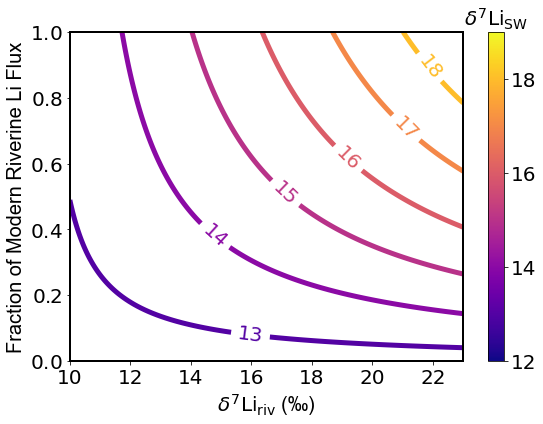

In [30]:
FONT_SIZE = 20
lw        = 5
axlw      = 2
afont = {'fontname':'Arial'}

fig     = plt.figure(figsize=(8,6))
fig.set_tight_layout(True)

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.

colorscalemin = 12
colorscalemax = 19
norm          = mpl.colors.Normalize(vmin=colorscalemin, vmax=colorscalemax)

# choose a colormap
c_m       = mpl.cm.plasma  # plasma, inferno, or copper

# create a ScalarMappable and initialize a data structure
s_m       = mpl.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

plt.xlim(10,delta_riv_range[-1]*1e3)
plt.ylim(0, frac_riv_range[-1])
plt.yticks(np.arange(0, 1.05, 0.2))
plt.xticks(np.arange(10, 23, 2))

ax  = plt.gca()
for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(axlw)

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
# plt.title(r'Sensitivity Test on $\delta^7{\rm Li}_{\rm riv}$ and $F_{{\rm riv}}$', size=FONT_SIZE, **afont)
plt.xlabel(r'$\delta^7{\rm Li}_{\rm riv}$'+' (\u2030)', fontsize=FONT_SIZE, **afont)
plt.ylabel(r'Fraction of Modern Riverine Li Flux', fontsize=FONT_SIZE, **afont)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)

cbar = plt.colorbar(mappable=s_m, ticks=[12, 14, 16, 18])
cbar.ax.tick_params(labelsize=FONT_SIZE)
cbar.ax.set_title(r'$\delta^7 {\rm Li}_{\rm SW}$', rotation='horizontal', fontsize=FONT_SIZE, **afont)

clevel  = np.array([13, 14, 15, 16, 17, 18]) # I
lb_pos  = [(16, 0.1), (15, 0.4), (17, 0.5), (19, 0.6), (21, 0.7), (22, 0.9)] 

# cs      = plt.contour(d_riv_grid*1e3, F_riv_grid, delta_mat*1e3, levels=clevel, linewidths=lw, cmap=c_m, vmin=colorscalemin, vmax=colorscalemax)
# labels  = plt.clabel(cs, inline=1, fontsize=FONT_SIZE, fmt='%3.1f')
cs      = plt.contour(d_riv_grid*1e3, F_riv_grid, delta_mat*1e3, levels=clevel, linewidths=lw, cmap=c_m, vmin=colorscalemin, vmax=colorscalemax)
labels  = plt.clabel(cs, inline=1, fontsize=FONT_SIZE, fmt='%2.0f', manual=lb_pos)

# plt.text(0.05, 0.05, 'I', transform=ax.transAxes, fontsize=FONT_SIZE, weight="bold", **afont)
fig.savefig('Sensitivity-Test.pdf', dpi = 300)

In [20]:
# np.max(np.max(delta_mat*1e3))
np.min(np.min(delta_mat*1e3))

12.570389215242894